In [15]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(520, IMG_SIZE)

In [16]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


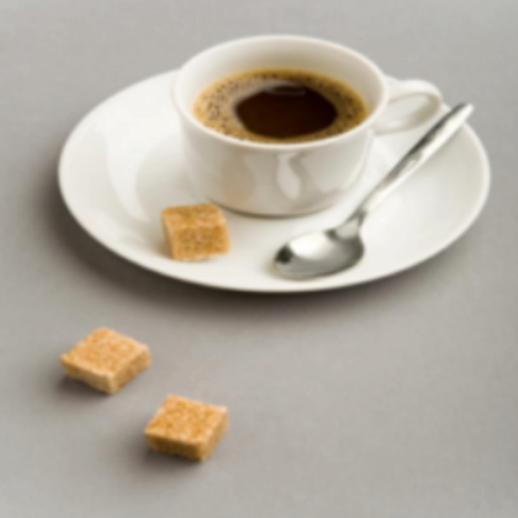

In [17]:
tensor, img = tr.load_image("data/coffee.png", transform)
tensor.to(torch.float16)
tensor = tensor.cuda()
img

In [18]:
shift_dists = [i for i in range(1, 3)]
transforms, inv_transforms = tr.get_shift_transforms(shift_dists, 'Moore')
net.set_transforms(transforms, inv_transforms)
#net.set_transforms([], [])
# run sequentially or we get OOM in attention calculation
hr_tensor, _ = net.forward(tensor)
hr_features = tr.to_numpy(hr_tensor)

In [19]:
c, h, w = hr_features.shape
reshaped = hr_features.reshape((c, h * w)).T
reshaped = standardize_img(reshaped)
cluster = KMeans(n_clusters=2)
data = cluster.fit_transform(reshaped)

/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


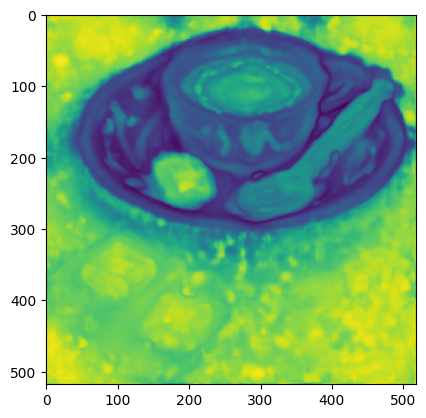

In [20]:
data2D = data.reshape(h, w, 2)
data2D = rescale_pca_img(data2D)
plt.imshow(data2D[:, :, 0])

In [21]:
from pydensecrf.utils import unary_from_softmax
d = dcrf.DenseCRF2D(w, h, 2)

energy = -1 * np.log(data)
#u = unary_from_softmax(np.ascontiguousarray(smax2D.T)) #np.ascontiguousarray(energy.T.astype(np.float32))
u = np.ascontiguousarray(energy.T.astype(np.float32))
d.setUnaryEnergy(u)
compat = [50, 15]
d.addPairwiseGaussian(sxy=(3, 3), compat=10, kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
d.addPairwiseBilateral(sxy=5, srgb=13, rgbim=np.array(img), compat=10, kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(10)

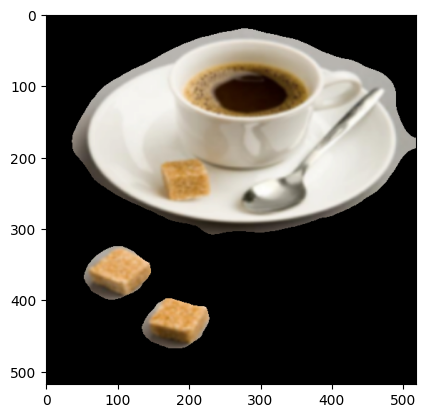

In [22]:
from skimage.morphology import binary_erosion
out = np.argmax(Q, axis=0)
binary = (out.reshape(h, w, 1))
eroded = binary
for i in range(4):
    eroded = binary_erosion(eroded)
plt.imshow(eroded * img)